In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

cats_and_dogs_filtered{train: {cats:, dogs}, validation: {cats:, dogs}}

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

In [3]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/home/texuanw/.keras/datasets
/home/texuanw/.keras/datasets/cats_and_dogs_filtered
/home/texuanw/.keras/datasets/cats_and_dogs_filtered/train
/home/texuanw/.keras/datasets/cats_and_dogs_filtered/train/cats
/home/texuanw/.keras/datasets/cats_and_dogs_filtered/train/dogs
/home/texuanw/.keras/datasets/cats_and_dogs_filtered/validation
/home/texuanw/.keras/datasets/cats_and_dogs_filtered/validation/cats
/home/texuanw/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print('--')

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print('Total training images:', total_train)
print('Total validation images:', total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting model parameters

In [6]:
BATCH_SIZE = 100
IMG_SHAPE = 150

# Data Preparation

In [7]:
# augment dataset by randomly applying horizontal flip, rotation and zoom
# To overcome overfitting
image_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest'
                                    )

In [8]:
train_data_gen = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE, IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [9]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=validation_dir,
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE, IMG_SHAPE),
                                                   class_mode='binary')


Found 1000 images belonging to 2 classes.


# Visualising training data

In [10]:
sample_training_images, _ = next(train_data_gen)

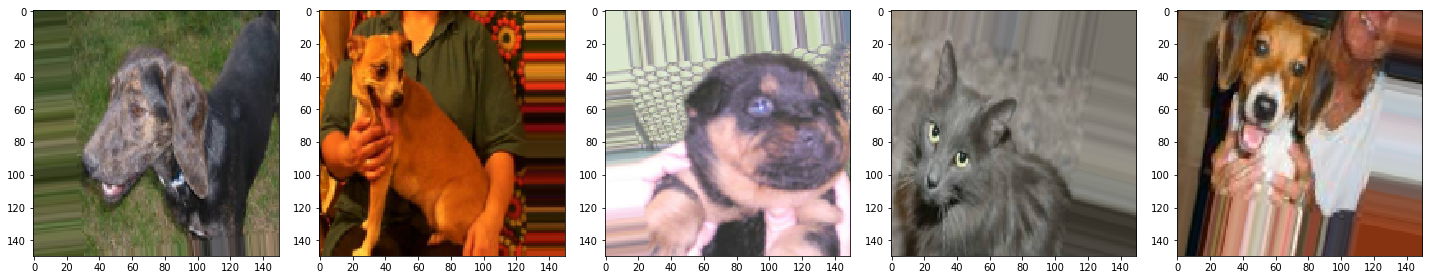

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

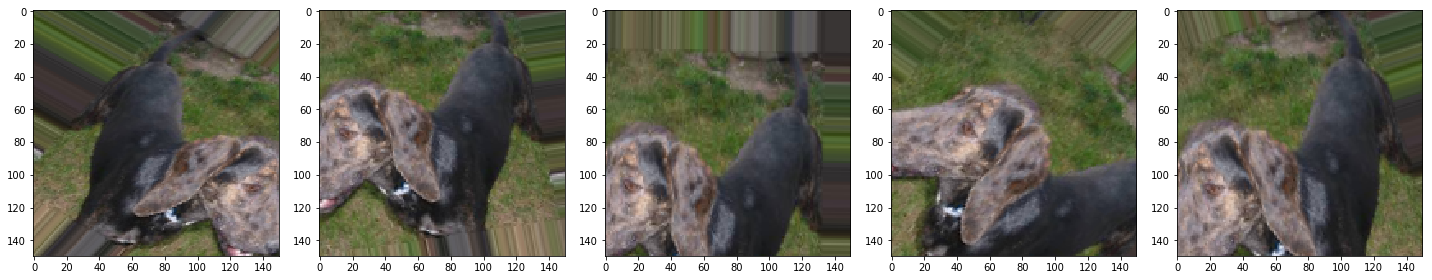

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Model
## Define

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.5),  # Avoid overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [14]:
# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Train

In [15]:
EPOCHS = 70
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train/float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val/float(BATCH_SIZE)))
)

Epoch 1/70
20/20 [==============================] - 28s 1s/step - loss: 0.6954 - acc: 0.5125 - val_loss: 0.6916 - val_acc: 0.5130
Epoch 2/70
20/20 [==============================] - 25s 1s/step - loss: 0.6883 - acc: 0.5510 - val_loss: 0.6764 - val_acc: 0.6120
Epoch 3/70
20/20 [==============================] - 25s 1s/step - loss: 0.6828 - acc: 0.5730 - val_loss: 0.6604 - val_acc: 0.6110
Epoch 4/70
20/20 [==============================] - 25s 1s/step - loss: 0.6707 - acc: 0.5805 - val_loss: 0.6528 - val_acc: 0.6470
Epoch 5/70
20/20 [==============================] - 25s 1s/step - loss: 0.6591 - acc: 0.5990 - val_loss: 0.6324 - val_acc: 0.6530
Epoch 6/70
20/20 [==============================] - 25s 1s/step - loss: 0.6392 - acc: 0.6195 - val_loss: 0.6329 - val_acc: 0.6530
Epoch 7/70
20/20 [==============================] - 25s 1s/step - loss: 0.6412 - acc: 0.6275 - val_loss: 0.6692 - val_acc: 0.5620
Epoch 8/70
20/20 [==============================] - 25s 1s/step - loss: 0.6458 - acc: 0.61

20/20 [==============================] - 25s 1s/step - loss: 0.4591 - acc: 0.7900 - val_loss: 0.4954 - val_acc: 0.7590
Epoch 40/70
20/20 [==============================] - 25s 1s/step - loss: 0.4532 - acc: 0.7910 - val_loss: 0.5489 - val_acc: 0.7350
Epoch 41/70
20/20 [==============================] - 25s 1s/step - loss: 0.4752 - acc: 0.7770 - val_loss: 0.5280 - val_acc: 0.7360
Epoch 42/70
20/20 [==============================] - 25s 1s/step - loss: 0.4563 - acc: 0.7890 - val_loss: 0.5171 - val_acc: 0.7540
Epoch 43/70
20/20 [==============================] - 25s 1s/step - loss: 0.4585 - acc: 0.7835 - val_loss: 0.5383 - val_acc: 0.7180
Epoch 44/70
20/20 [==============================] - 25s 1s/step - loss: 0.4398 - acc: 0.7995 - val_loss: 0.4825 - val_acc: 0.7640
Epoch 45/70
20/20 [==============================] - 25s 1s/step - loss: 0.4405 - acc: 0.7970 - val_loss: 0.5137 - val_acc: 0.7440
Epoch 46/70
20/20 [==============================] - 25s 1s/step - loss: 0.4042 - acc: 0.8180 -

# Visualizing results of the training

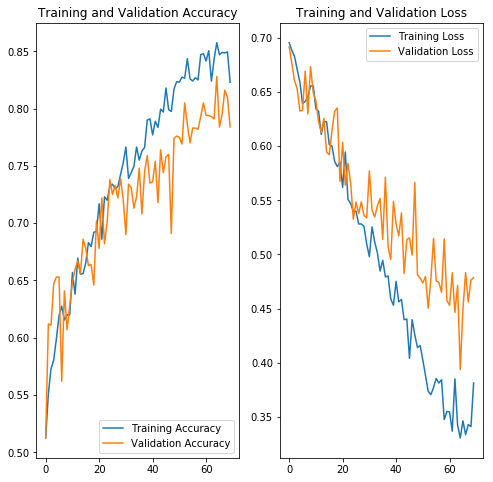

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./acc-loss.png')
plt.show()